In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
imp

import xgboost as xgb
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

NameError: name 'imp' is not defined

In [4]:
# Load in the train and test datasets
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

# Store our passenger ID for easy access

train.head(3)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


<table>
<tbody>
<tr><th><b>Variable</b></th><th><b>Definition</b></th><th><b>Key</b></th></tr>
<tr>
<td>survival</td>
<td>Survival</td>
<td>0 = No, 1 = Yes</td>
</tr>
<tr>
<td>pclass</td>
<td>Ticket class</td>
<td>1 = 1st, 2 = 2nd, 3 = 3rd</td>
</tr>
<tr>
<td>sex</td>
<td>Sex</td>
<td></td>
</tr>
<tr>
<td>Age</td>
<td>Age in years</td>
<td></td>
</tr>
<tr>
<td>sibsp</td>
<td># of siblings / spouses aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>parch</td>
<td># of parents / children aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>ticket</td>
<td>Ticket number</td>
<td></td>
</tr>
<tr>
<td>fare</td>
<td>Passenger fare</td>
<td></td>
</tr>
<tr>
<td>cabin</td>
<td>Cabin number</td>
<td></td>
</tr>
<tr>
<td>embarked</td>
<td>Port of Embarkation</td>
<td>C = Cherbourg, Q = Queenstown, S = Southampton</td>
</tr>
</tbody>
</table>

## 是否存活 船舱等级(1/2/3) 名字 性别 年龄 兄弟姐妹或配偶数量 父母或孩子数量 船票编号 船票价格 船舱号登船地点(C/Q/S)

In [5]:
test.head(3)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [7]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

In [21]:
print(os.path.abspath('.'))#当前的路径
print(os.getcwd())#当前工作路径

D:\python\Deep_learning\KTaEgXgTl1e\Titanic\input
D:\python\Deep_learning\KTaEgXgTl1e\Titanic\input


In [32]:
a = float('nan')
print(type(a))
print(a)

<class 'float'>
nan


In [13]:
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,1.0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,2.0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1.0,0


In [47]:
print(type(test))

<class 'pandas.core.frame.DataFrame'>


In [9]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [12]:
train.Embarked = train.Embarked.map(lambda x: {'S':1,'C':2,'Q':3}.get(x, x))
test.Embarked = test.Embarked.map(lambda x: {'S':1,'C':2,'Q':3}.get(x, x))
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,2.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1.0


In [15]:
train.Sex = train.Sex.map(lambda x: {'male':1,'female':2}.get(x, x))
test.Sex = test.Sex.map(lambda x: {'male':1,'female':2}.get(x, x))
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,1.0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.0,1,0,PC 17599,71.2833,C85,2.0,1
2,3,1,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1.0,0


In [22]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null float64
Has_Cabin      891 non-null int64
dtypes: float64(3), int64(7), object(3)
memory usage: 90.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null int64
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object


In [19]:
train['Embarked'].fillna(0,inplace=True)

In [21]:
train['Age'].fillna(-1,inplace=True)
test['Age'].fillna(-1,inplace=True)

In [24]:
train_ans = train.drop(['PassengerId','Name','Ticket','Cabin'], axis = 1)
train_ans.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Has_Cabin
0,0,3,1,22.0,1,0,7.2500,1.0,0
1,1,1,2,38.0,1,0,71.2833,2.0,1
2,1,3,2,26.0,0,0,7.9250,1.0,0
3,1,1,2,35.0,1,0,53.1000,1.0,1
4,0,3,1,35.0,0,0,8.0500,1.0,0


In [25]:
train_np = np.array(train_ans)
print(train_np)

[[ 0.      3.      1.     ...  7.25    1.      0.    ]
 [ 1.      1.      2.     ... 71.2833  2.      1.    ]
 [ 1.      3.      2.     ...  7.925   1.      0.    ]
 ...
 [ 0.      3.      2.     ... 23.45    1.      0.    ]
 [ 1.      1.      1.     ... 30.      2.      1.    ]
 [ 0.      3.      1.     ...  7.75    3.      0.    ]]


In [26]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null int64
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null int64
Has_Cabin      418 non-null int64
dtypes: float64(2), int64(7), object(3)
memory usage: 39.3+ KB


In [27]:
test_ans = test.drop(['PassengerId','Name','Ticket','Cabin'], axis = 1)
test_ans.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Has_Cabin
0,3,1,34.5,0,0,7.8292,3,0
1,3,2,47.0,1,0,7.0000,1,0
2,2,1,62.0,0,0,9.6875,3,0
3,3,1,27.0,0,0,8.6625,1,0
4,3,2,22.0,1,1,12.2875,1,0


In [30]:
test_np = np.array(test_ans)
print(test_np)

[[ 3.      1.     34.5    ...  7.8292  3.      0.    ]
 [ 3.      2.     47.     ...  7.      1.      0.    ]
 [ 2.      1.     62.     ...  9.6875  3.      0.    ]
 ...
 [ 3.      1.     38.5    ...  7.25    1.      0.    ]
 [ 3.      1.     -1.     ...  8.05    1.      0.    ]
 [ 3.      1.     -1.     ... 22.3583  2.      0.    ]]


In [65]:
# KNN
result =  np.zeros((418,2),dtype=int)
#print(result)
i=892
for tnp in test_np :
    maxn = 10000000
    for jnp in train_np:
        s=0
        for j in range(0,len(tnp)):
            s=s+(tnp[j]-jnp[j+1])**2
        if s < maxn :
            maxn = s
            result[i-892]=[i,jnp[0]]
    i=i+1
    print(i,end=',')

893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,11

In [56]:
print(result)

[[ 892    0]
 [ 893    0]
 [ 894    1]
 [ 895    1]
 [ 896    0]
 [ 897    0]
 [ 898    0]
 [ 899    1]
 [ 900    1]
 [ 901    0]
 [ 902    0]
 [ 903    0]
 [ 904    1]
 [ 905    0]
 [ 906    0]
 [ 907    1]
 [ 908    0]
 [ 909    1]
 [ 910    1]
 [ 911    0]
 [ 912    1]
 [ 913    1]
 [ 914    0]
 [ 915    1]
 [ 916    1]
 [ 917    0]
 [ 918    1]
 [ 919    1]
 [ 920    1]
 [ 921    0]
 [ 922    1]
 [ 923    1]
 [ 924    0]
 [ 925    0]
 [ 926    1]
 [ 927    0]
 [ 928    0]
 [ 929    0]
 [ 930    0]
 [ 931    1]
 [ 932    0]
 [ 933    0]
 [ 934    0]
 [ 935    1]
 [ 936    1]
 [ 937    0]
 [ 938    0]
 [ 939    0]
 [ 940    1]
 [ 941    0]
 [ 942    1]
 [ 943    0]
 [ 944    1]
 [ 945    1]
 [ 946    0]
 [ 947    0]
 [ 948    0]
 [ 949    0]
 [ 950    0]
 [ 951    1]
 [ 952    0]
 [ 953    1]
 [ 954    0]
 [ 955    1]
 [ 956    1]
 [ 957    0]
 [ 958    1]
 [ 959    1]
 [ 960    0]
 [ 961    0]
 [ 962    0]
 [ 963    0]
 [ 964    0]
 [ 965    0]
 [ 966    1]
 [ 967    1]
 [ 968    0]

In [42]:
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null int64
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null int64
Has_Cabin      418 non-null int64
dtypes: float64(2), int64(7), object(3)
memory usage: 39.3+ KB


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,3,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",2,47.0,1,0,363272,7.0000,NaN,1,0
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,3,0
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,1,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",2,22.0,1,1,3101298,12.2875,NaN,1,0


In [62]:

np.savetxt('result.csv', result, delimiter = ',')

In [60]:
print(type(result))
print(result.shape)

<class 'numpy.ndarray'>
(500, 2)


In [66]:
result_1 = pd.DataFrame(result)

In [72]:
print(result_1)

     PassengerId  Survived
0            892         0
1            893         0
2            894         1
3            895         1
4            896         0
5            897         0
6            898         0
7            899         1
8            900         1
9            901         0
10           902         0
11           903         0
12           904         1
13           905         0
14           906         0
15           907         1
16           908         0
17           909         1
18           910         1
19           911         0
20           912         1
21           913         1
22           914         0
23           915         1
24           916         1
25           917         0
26           918         1
27           919         1
28           920         1
29           921         0
..           ...       ...
388         1280         0
389         1281         0
390         1282         1
391         1283         1
392         1284         1
3

In [77]:
result_1.to_csv('result.csv',index=False)

In [71]:
#result_1.rename(columns={'a':'A'})
result_1.columns = ['PassengerId','Survived']

### 分析数据之间是否存在关系

In [78]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

In [79]:
test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [80]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


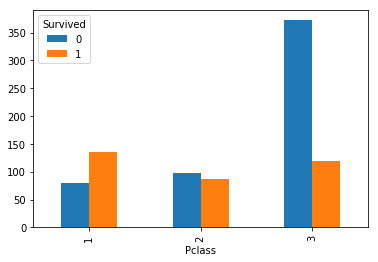

In [92]:
grouped_bins = train.groupby(['Survived','Pclass'])
grouped_bins.size().unstack(0).plot(kind='bar')

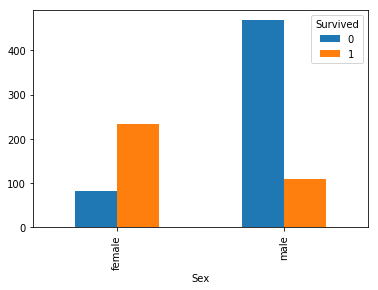

In [93]:
grouped_bins = train.groupby(['Survived','Sex'])
grouped_bins.size().unstack(0).plot(kind='bar')

In [95]:
grouped_bins = train.groupby(['Survived','Age'])
grouped_bins.size().unstack(0)

Survived,0,1
Age,,
0.42,NaN,1.0
0.67,NaN,1.0
0.75,NaN,2.0
0.83,NaN,2.0
0.92,NaN,1.0
1.00,2.0,5.0
2.00,7.0,3.0
3.00,1.0,5.0
4.00,3.0,7.0


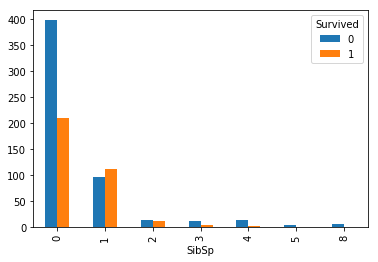

In [97]:
grouped_bins = train.groupby(['Survived','SibSp'])
grouped_bins.size().unstack(0).plot(kind="bar")

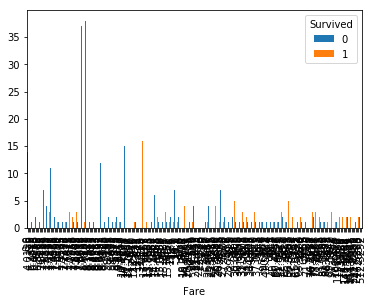

In [99]:
grouped_bins = train.groupby(['Survived','Parch'])
grouped_bins.size().unstack(0).plot(kind="bar")

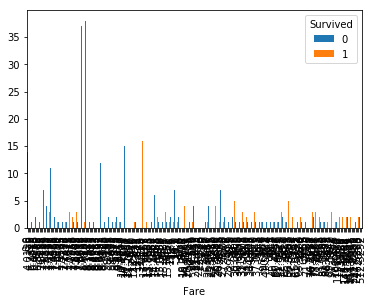

In [100]:
grouped_bins = train.groupby(['Survived','Fare'])
grouped_bins.size().unstack(0).plot(kind="bar")

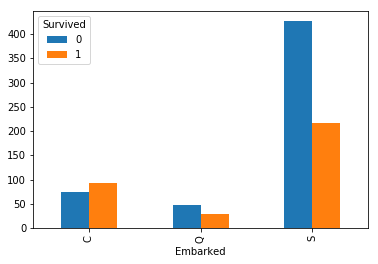

In [101]:
grouped_bins = train.groupby(['Survived','Embarked'])
grouped_bins.size().unstack(0).plot(kind="bar")

In [102]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200
